# Complex networks and graph theory

Preamble: Run the cells below to import the necessary Python packages

<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/intro_graph_adjacency.ipynb) -->
Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/intro_graph_adjacency.ipynb)

In [3]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# A large matrix dataset: coauthorship among physicists

We will use a coauthorship network among physicists based arXiv postings in the `astro-ph` category. This graph contains $N = 18772$ nodes, which correspond to unique authors observed over the period 1993 -- 2003. If Author i and Author j coauthored a paper during that period, the nodes are connected. In order to analyze this large graph, we will downsample it to a smaller graph with $N = 1000$ nodes representing the most highly-connected authors.

This dataset is from the [Stanford SNAP database](https://snap.stanford.edu/data/ca-CondMat.html)



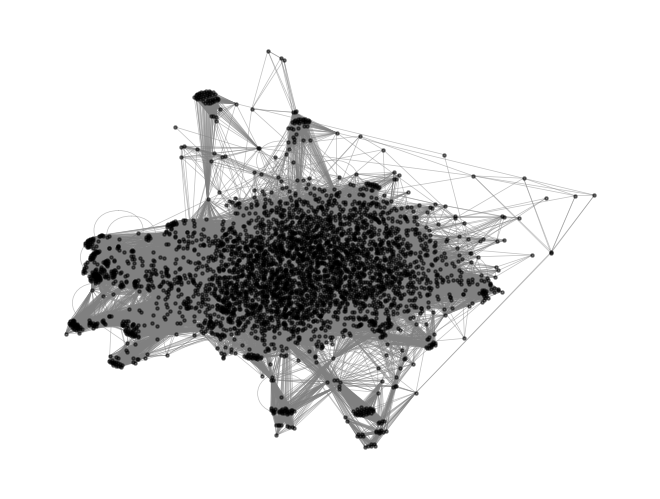

In [53]:
import networkx as nx
## Load the full coauthorship network
fpath = "../resources/ca-AstroPh.txt.gz"
# fpath = "../resources/ca-CondMat.txt.gz" # This graph has disconnected components

g = nx.read_edgelist(fpath)

## Create a subgraph of the 1000 most connected authors
subgraph = sorted(g.degree, key=lambda x: x[1], reverse=True)[:4000]
subgraph = [x[0] for x in subgraph]
g2 = g.subgraph(subgraph)
# rename nodes to sequential integers as they would appear in an adjacency matrix
g2 = nx.convert_node_labels_to_integers(g2, first_label=0)

pos = nx.spring_layout(g2)
# pos = nx.kamada_kawai_layout(g2)
# nx.draw_spring(g2, pos=pos, node_size=10, node_color='black', edge_color='gray', width=0.5)
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
plt.show()

# Representing graphs as matrices

We can think of graphs as large, and often sparse, matrices. A graph among $N$ nodes (here, authors) can be represented as an $N \times N$ adjacency matrix $A$, where $A_{ij} = 1$ if there is an edge between nodes $i$ and $j$. Otherwise, $A_{ij} = 0$. In the case of coauthorship, we have an undirected graph, because if Author i and Author j coauthored a paper, then Author j and Author i coauthored a paper. The adjacency matrix is thus a symmetric matrix ($A_{ij} = A_{ji}$), and so there are at most $N(N-1)/2$ unique edges in the graph. However, in practice, there are far fewer edges than that.

In [54]:
A = nx.adjacency_matrix(g2).todense()
print(A.shape)
# find sparsity

n = A.shape[0]
density = np.sum(A != 0) / (n * (n-1))
print("Density: {:.2f}%".format(density * 100))

(4000, 4000)
Density: 1.26%


To understand this matrix a little more closely, we can look at the sparsity pattern of the matrix. 

Text(0, 0.5, 'Author')

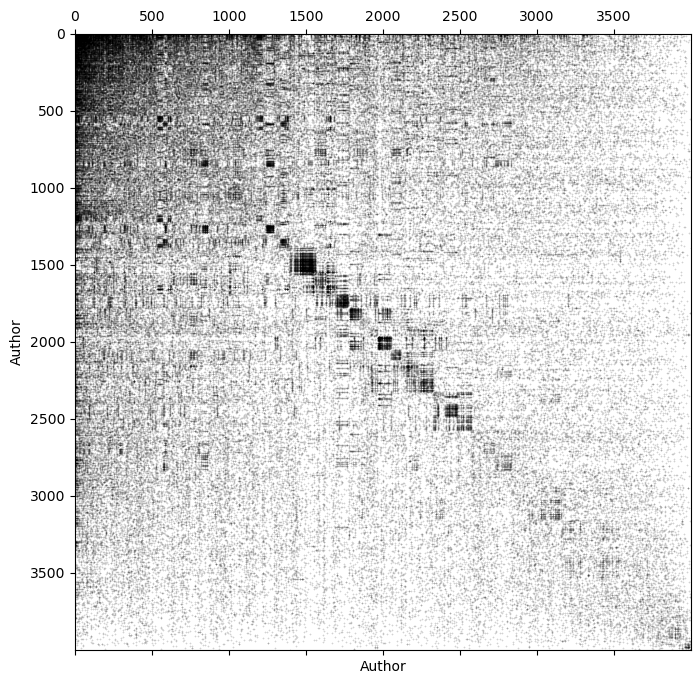

In [57]:
plt.figure(figsize=(8, 8))
# plt.spy(A[:500, :500], markersize=2, color='k') # a spy plot is a plot of the sparsity pattern of a matrix
# plt.spy(A, markersize=0.05, color='k') # a spy plot is a plot of the sparsity pattern of a matrix
sort_inds = np.argsort(np.sum(A, axis=0))[::-1]
plt.spy(A[sort_inds][:, sort_inds], markersize=0.05, color='k')
plt.xlabel("Author")    
plt.ylabel("Author")

### A random walk on the coauthorship network

We can think of a random walk on the graph as a random walk defined by the adjacency matrix $A$.  The probability of transitioning from node $i$ to node $j$ is $A_{ij} / \sum_k A_{ik}$, while the probability of transitioning from node $i$ to node $j$ in $n$ steps is $A^n_{ij} / \sum_k A^n_{ik}$.

For the coauthorship graph, we can think of this as a highly-simplified model of collaboration: If one author initially collaborates with another author, then we randomly choose one of their collaborators, and so on. In this simplified model, the probability of collaborating with a given author is proportional to the number of collaborators they have. So authors with high degree (many collaborators) are more likely to be chosen eventually

We thus introduce the degree distribution of the graph, which corresponds to a histogram of the number of edges per node. For this graph, the degree distribution represents the number of cumulative unique coauthors per author.

Text(0.5, 1.0, 'Median number of coauthors: 41.00')

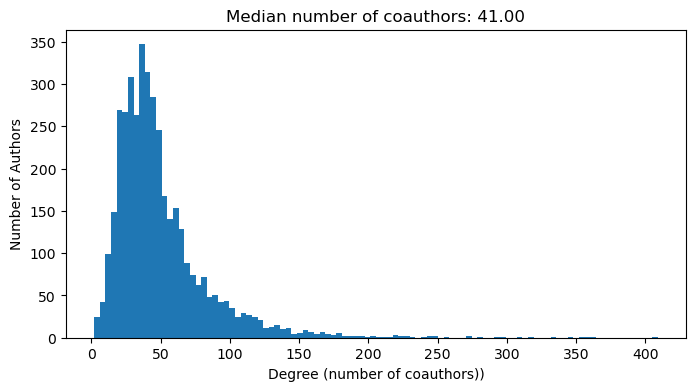

In [58]:
# degree distribution
degrees = np.sum(A, axis=0)
plt.figure(figsize=(8, 4))
plt.hist(degrees, bins=100);
plt.xlabel("Degree (number of coauthors))")
plt.ylabel("Number of Authors")
plt.title(f"Median number of coauthors: {np.median(degrees):.2f}")

Now let's implement the random walk on the graph of `astro-ph` coauthorship.

Text(0, 0.5, 'Node')

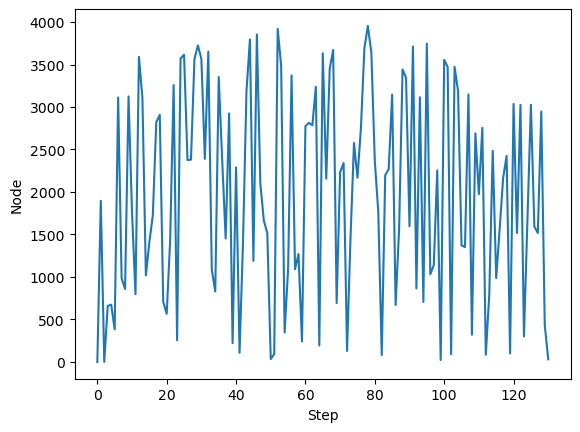

In [59]:
class GraphRandomWalk:
    """A class for performing random walks on a graph

    Parameters:
        A (np.ndarray): The adjacency matrix of the graph
        random_state (int): The random seed to use
        store_history (bool): Whether to store the history of the random walk
    """

    def __init__(self, A, random_state=None, store_history=False):
        self.A = A
        self.n = A.shape[0]
        self.degrees = np.sum(A, axis=0)
        self.D = np.diag(self.degrees)

        self.random_state = random_state
        self.store_history = store_history

        np.random.seed(self.random_state)

        if self.store_history:
            self.history = []

    def step(self, curr):
        """
        Take a single step from a given node to any of its neighbors with equal 
        probability

        Args:
            curr (int): The current node

        Returns:
            nxt (int): The next
        """
        choices = A[curr, :].nonzero()[0]
        nxt = np.random.choice(choices)
        return nxt


    def random_walk(self, start, steps):
        """Perform a random walk on the graph

        Args:
            start (int): The starting node
            steps (int): The number of steps to take

        Returns:
            stop (int): The final node
        """
        curr = start
        if self.store_history:
            self.history.append(start)
        for _ in range(steps):
            curr = self.step(curr)
            if self.store_history:
                self.history.append(curr)

        return curr

model = GraphRandomWalk(A, random_state=0, store_history=True)

# simulate a random walk starting from node 0 for 130 timesteps
model.random_walk(0, 130)

plt.plot(model.history)
plt.xlabel("Step")
plt.ylabel("Node")

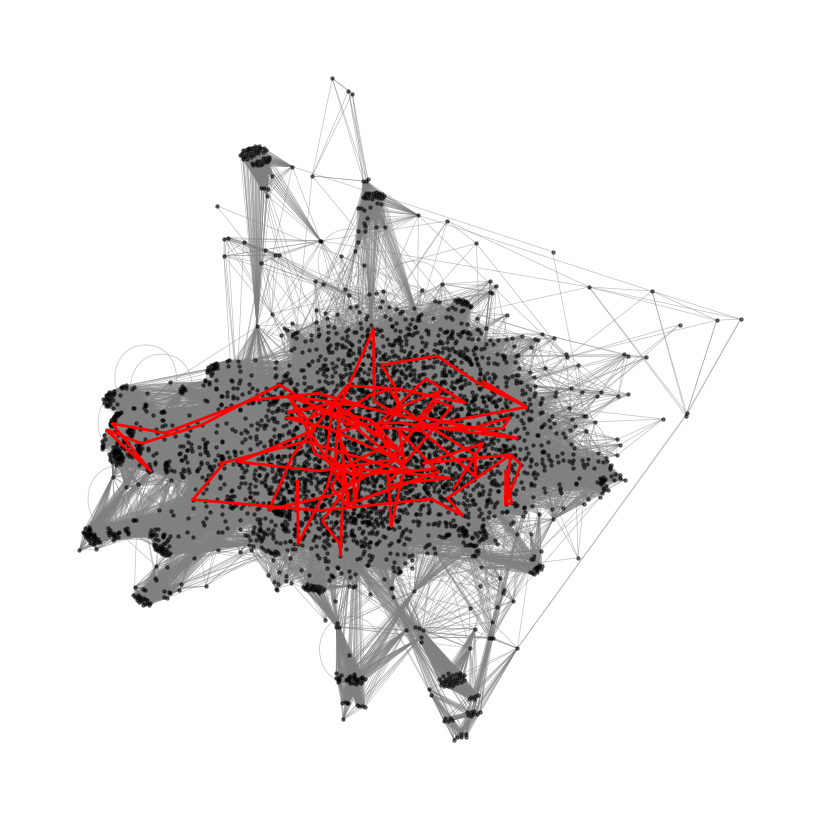

In [60]:

plt.figure(figsize=(8, 8))
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
traj = [pos[item] for item in model.history]
plt.plot(*zip(*traj), color='red', linewidth=2)
plt.show()

Now, let's simulate an ensemble of random walks on the graph of `astro-ph` coauthorship.

We will initialize each random walk at the same node (the node with the highest degree, i.e., the author with the most collaborators). We will then simulate the random walk for $n = 100$ steps. We will repeat this process for $N_{\text{walks}} = 1000$ random walks.

In [39]:
all_traj = []
for _ in range(1000):
    model = GraphRandomWalk(A,  store_history=True)
    model.random_walk(0, 130) # simulate a random walk starting from node 0 for 130 timesteps
    all_traj.append(np.array(model.history).copy())

We will plot all of these random walks on top of each other, with a small amount of transparency so that we can see regions of high density.

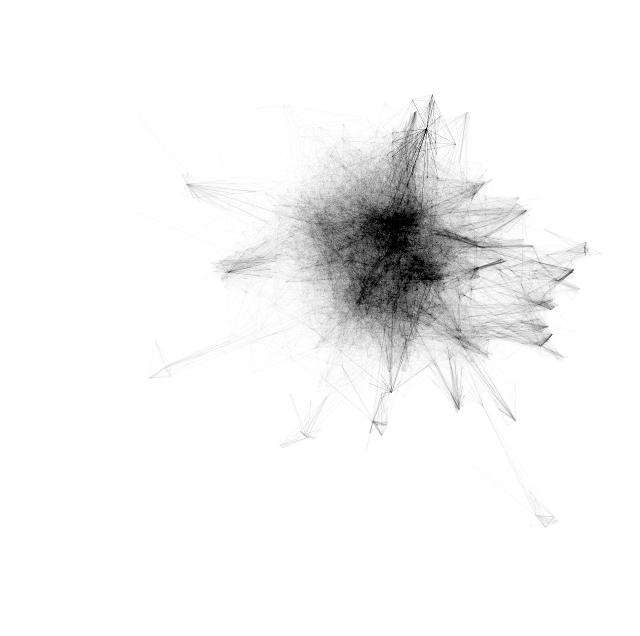

In [53]:
plt.figure(figsize=(8, 8))
for traj in all_traj:
    traj = [pos[item] for item in traj]
    plt.plot(*zip(*traj), color='k', linewidth=.2, alpha=0.01)
plt.axis('off');

### Does the degree alone determine the probability of visiting a node?

The degree of a node is defined as the number of edges connected to it. We can compare this number to the empirical probability of visiting a node across our ensemble of random walks.


Text(0, 0.5, 'Number of visits')

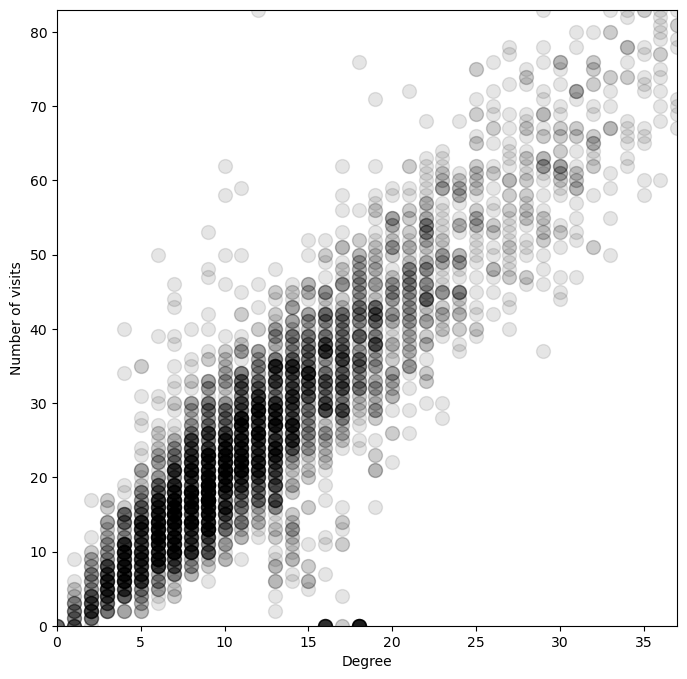

In [43]:
# The degree of each author
degrees = np.sum(A, axis=0)

# The number of times each author was visited across all walks
all_visits = np.hstack(all_traj) # Shape N_walks * N_steps
vals, bins = np.histogram(all_visits, bins=np.arange(0, len(degrees) + 1))

plt.figure(figsize=(8, 8))
plt.plot(degrees, vals, '.k', markersize=20, alpha=0.1)
plt.xlim(0, np.percentile(degrees, 95))
plt.ylim(0, np.percentile(vals, 95))

plt.xlabel("Degree")
plt.ylabel("Number of visits")

So the degree distribution tells us a lot about the long-term behavior of our random walk process.
$$
D_i = \sum_j A_{ij} 
$$

We can write the degree distribution as a matrix equation for the vector $D$,

$$
D = A \, \mathbb{1}
$$

where $\mathbb{1}$ is a vector of ones.






# First passage times on the network of collaborators

We can see that the random walk is biased towards nodes with high degree (many collaborators). That means that the ensemble of random walks has non-uniform measure on the graph of collaborators. Suppose we start out at the node with the highest degree. **How long does it take to reach a given node?** This is equivalent to the first passage time problem for a random walk on the graph.

We can study this problem by simulating a random walk on the graph, and recording the first passage time to each node. We will implement this as a class that inherits from the `GraphRandomWalk` class.

In [61]:
class FirstPassageTime(GraphRandomWalk):
    """A class for computing the first passage time distribution

    Parameters:
        A (np.ndarray): The adjacency matrix of the graph
        random_state (int): The random seed to use
        max_iter (int): The maximum number of iterations to use
        store_history (bool): Whether to store the history of the random walk
    """

    def __init__(self, A, max_iter=10000, random_state=None, store_history=False):
        self.A = A
        self.max_iter = max_iter
        self.random_state = random_state
        self.store_history = store_history
        np.random.seed(self.random_state)

        if self.store_history:
            self.history = []


    def fpt(self, start, stop):
        """Compute a single first passage time from a starting node to a stopping node

        Args:
            start (int): The starting node
            stop (int): The stopping node
            steps (int): The maximum number of steps to take

        Returns:
            fpt (int): The first passage time
        """
        curr = start
        if self.store_history:
            self.history.append(start)

        for i in range(self.max_iter):
            curr = self.step(curr)
            if self.store_history:
                self.history.append(curr)
            if curr == stop:
                return i

        return np.inf


fpt = FirstPassageTime(A, random_state=0, store_history=True, max_iter=100000)
fpt.fpt(0, 10) # find the time it takes to walk from node 0 to node 10

12841

We now run the first passage time between the node with the highest degree and the second highest node, compared to the highest degree node to the $15^{th}$ highest node.

In [62]:
all_paths_close, all_fpts_close = [], []
all_paths_far, all_fpts_far = [], []

for _ in range(100):
    fpt = FirstPassageTime(A, store_history=True, max_iter=100000)
    all_fpts_close.append(fpt.fpt(0, 3))
    all_paths_close.append(fpt.history)

    fpt = FirstPassageTime(A, store_history=True, max_iter=100000)
    all_fpts_far.append(fpt.fpt(0, 100))
    all_paths_far.append(fpt.history)

# print number that didn't converge within max_iter
print("Number of paths that didn't converge within max_iter: {}".format(np.sum(np.isinf(all_fpts_close))))
print("Number of paths that didn't converge within max_iter: {}".format(np.sum(np.isinf(all_fpts_far))))

Number of paths that didn't converge within max_iter: 0
Number of paths that didn't converge within max_iter: 0


Mean FPT between distant authors: 8825.31
Mean FPT between close authors: 4038.19


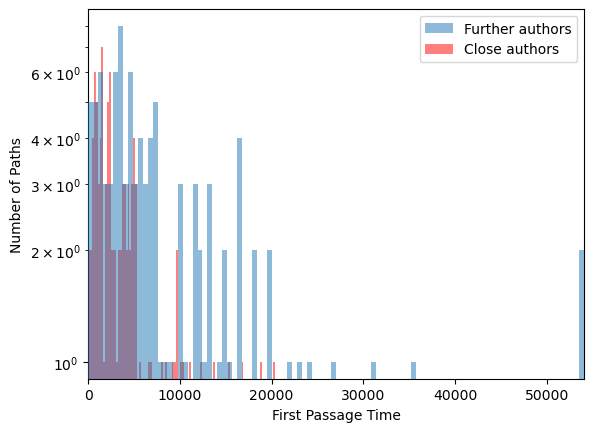

In [37]:
plt.semilogy()
plt.hist(all_fpts_far, bins=100, alpha=0.5, label="Further authors", zorder=5);
plt.hist(all_fpts_close, bins=100, alpha=0.5, label="Close authors", color='r');
plt.xlabel("First Passage Time")
plt.ylabel("Number of Paths")
plt.xlim([0, np.max(all_fpts_far)])
plt.legend()

print("Mean FPT between distant authors: {:.2f}".format(np.mean(all_fpts_far)))
print("Mean FPT between close authors: {:.2f}".format(np.mean(all_fpts_close)))


We naively expect that the first passage time is proportional to the degree of the node. That is, the more collaborators an author has, the more likely it is that we will collaborate with them after a fixed number of steps

We will compare the first passage time between the most highly-connected node (most collaborators) and the second-most highly-connected node (second-most collaborators), as compared to the first passage time between the most highly-connected node and a less-connected node (fewer collaborators).

(-0.7772509068250656,
 0.5980996698141098,
 -0.9608237326145173,
 0.6776723444461823)

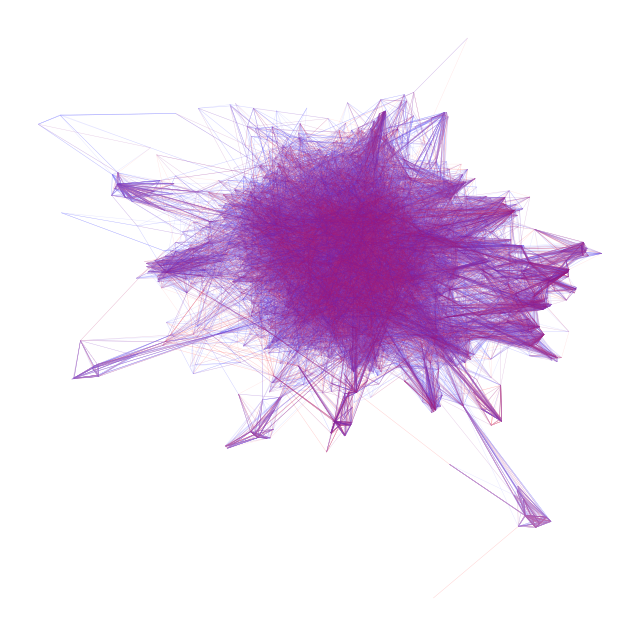

In [42]:
plt.figure(figsize=(8, 8))
for traj1, traj2 in zip(all_paths_far[:10], all_paths_close[:100]):
    traj1 = [pos[item] for item in traj1]
    traj2 = [pos[item] for item in traj2]
    plt.plot(*zip(*traj1), color='b', linewidth=.3, alpha=0.1)
    plt.plot(*zip(*traj2), color='r', linewidth=.3, alpha=0.1)
plt.axis('off')

# Can we compute this analytically?

We can now compute the first passage time analytically. Much as we previously saw with random walks on the line, we can pass between the dynamics of single walkers (particles), and the dynamics of a distribution (ensemble). From the adjacency matrix $A$, we can construct a transition matrix $T$ such that

$$
T_{ij} = \frac{A_{ij}}{\sum_k A_{ik}}
$$

This matrix defines a discrete-time Markov chain on the graph. Given a *starting distribution* $\pi_0 \in \mathbb{R}^N$, we can compute the distribution of the random walk after $n$ steps as

$$
\pi_n = T^n \pi_0 
$$

where $\pi_n$ is the distribution of the random walk after $n$ steps, and $T^n$ is the transition matrix applied $n$ times.

In the case above, our starting distribution is $\pi_0 = \delta_{i, \text{max}}$, where $\delta_{i, \text{max}}$ is the Kronecker delta function, which is 1 if $i = \text{max}$ and 0 otherwise. That is, we always start out at the node with the highest degree.


In [ ]:
# make the transition matrix from the adjacency matrix

# normalize the adjacency matrix
D = np.diag(np.sum(A, axis=0))
T = np.linalg.inv(D) @ A

We are now ready to solve for the first passage time analytically. We have already seen two matrices, the adjacency matrix $A$ and the transition matrix $T$. We now introduce the *first passage time matrix* $F$. The $(i, j)$ entry of $F$ is the *expected* number of steps it takes to reach node $j$ from node $i$. In other words, on average we expect to reach node $j$ after $F_{ij}$ steps.

We can write down this matrix in terms of the transition matrix $T$ as

$$
F_{ij} = \delta_{ij} + \sum_{k \neq j} T_{ik} (F_{kj} + 1)
$$

We can interpret this matrix equation as follows: the first passage time from node $i$ to node $j$ is 1 if $i = j$ (we are already at node $j$), and otherwise it is the sum of the first passage times from node $k$ to node $j$, times the probability of transitioning from node $i$ to node $k$.

This recursive equation captures the intution that a walker starting at $i$ has a probability $T_{ik}$ of transitioning to each of the other nodes $k$, and each of those nodes has its own associated first passage time $F_{kj}$. However, because it takes at least one step to transition from $i$ to $k$, we add 1 to the first passage time from $k$ to $j$.

We can re-write this equation in matrix form as

$$
F = I + T (F + I)
$$

Solving, we find

$$
F = (I - T)^{-1}
$$

where $I$ is the identity matrix. We can now compute the first passage time from node $i$ to node $j$ as $F_{ij}$.

Let's compute the first passage time matrix $F$ for the graph of `astro-ph` coauthorship.


In [74]:
# check that the rows sum to 1
T = A / np.sum(A, axis=1, keepdims=True)
print(np.allclose(np.sum(T, axis=1), 1))

# compute the first passage time distribution
fpt = np.linalg.inv(np.identity(T.shape[0]) - T)

print("Mean FPT for distant authors: {:.2f}".format(fpt[0, 1]))
print("Mean FPT for closer authors: {:.2f}".format(fpt[0, 15]))

True
Mean FPT for distant authors: 11879181163822.11
Mean FPT for closer authors: 4148285485779.14


In [69]:
all_fpt_empirical = list()
for seed in range(100):
    fpt = FirstPassageTime(A, store_history=True, max_iter=100000, random_state=seed)
    all_fpt_empirical.append(fpt.fpt(0, 10))
print(np.mean(all_fpt_empirical))

7485.34


### The PageRank algorithm

We can see that the occupation probability of a node is correlated to the degree of the node. What if we want an alternative measure of centrality?

The PageRank algorithm generalizes the notion of degree centrality to a notion of *link centrality*. We simulate a random walk on the graph, but we include a *damping factor* that allows the walker to jump to a random node with some probability. Below, we compute the PageRank centrality for a range of damping factors.

In [90]:
# PageRank centrality

# normalize the adjacency matrix
T = A / np.sum(A, axis=1, keepdims=True)

d = 0.85 # damping factor (probability of following a link)

all_page_ranks = []
for d in np.linspace(1e-10, 1.0 - 1e-10, 9):
    page_rank = np.linalg.inv(np.identity(T.shape[0]) - d * A @ np.linalg.inv(D)) @ np.ones((T.shape[0], 1))
    all_page_ranks.append(page_rank)
all_page_ranks = np.array(all_page_ranks)

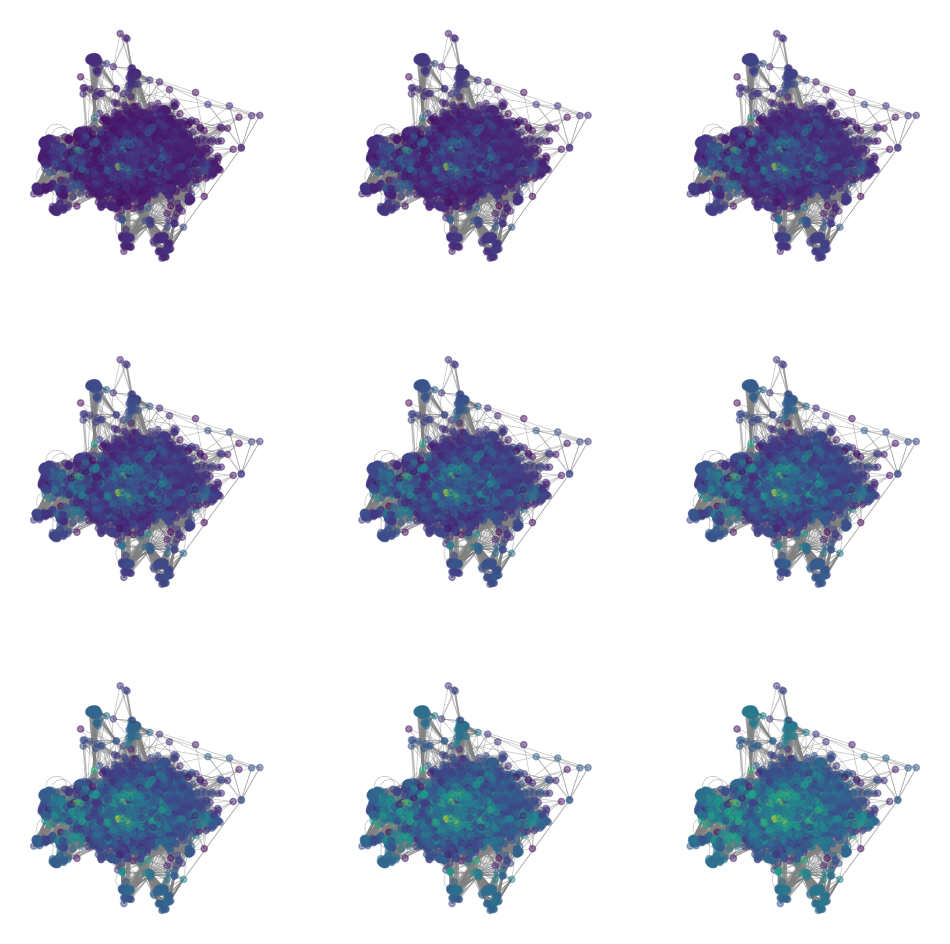

In [92]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    nx.draw(g2, pos=pos, node_size=20, node_color=np.log(all_page_ranks[i]), 
        edge_color='gray', width=0.5, alpha=0.5)


[Newman (2005)](https://doi.org/10.1007/978-3-540-44485-5_16) explores unique properties of the coauthorship network of physicists, including a powerlaw degree distribution.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/newman2005.png" style="max-width:50%; height:auto;">

<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>